<a href="https://colab.research.google.com/github/YaZlob/ML_project/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: Fashion-MNIST



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from copy import deepcopy
from torchvision.utils import make_grid
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))])

batch_size = 128
trainset = torchvision.datasets.FashionMNIST(root='./dataset', train=True,
                                        download=True, transform=transform)
only_one_clothes_type =[]
for image,label in trainset:
    if label == 3:
       only_one_clothes_type.append([image,label])

trainloader = torch.utils.data.DataLoader(only_one_clothes_type, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
label_decoder = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class Generator(nn.Module):
    def __init__(self,latent_size=512):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.create_block(512,256,ks=4,st=1,p=0),       #1,1-> 4,4
            self.create_block(256,128,ks=4,st=2,p=1),       #4,4-> 8,8
            self.create_block(128,64,ks=4,st=2,p=1),        #8,8-> 16,16
            self.create_block(64,32,ks=2,st=2,p=1),         #16,16-> 30,30
            self.create_block(32,1,ks=3,last = True)        #30,30-> 28,28    
        )
    
    def create_block(self,in_c:int,out_c:int,ks=4,p=1, st=1, last=False):
        if last:
            layer = nn.Sequential(
                nn.Conv2d(in_channels=in_c,out_channels=1,kernel_size=ks,
                          stride=st),
                nn.Tanh(
                    
                )
            )
            return layer
        layer = nn.Sequential(
          nn.ConvTranspose2d(in_channels=in_c,out_channels=out_c,kernel_size=ks,
                          stride=st,padding = p),
          nn.BatchNorm2d(out_c),
          nn.ReLU()
        )
        return layer
    def forward(self,x):
      return self.net(x)

    def _check(self):
      noise = torch.rand((32,512,1,1),dtype=torch.float32)
      out = self.forward(noise)
      assert out.shape == torch.Size([32,1,28,28])

Gen = Generator()
Gen._check()
      

In [4]:
class Discriminator(nn.Module):
    def __init__(self,out_size=1):
        self.out_neuron = out_size
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            self.create_block(1,8,p=1,st=2),  # bs,8,14,14
            self.create_block(8,16,p=1,st=2), # bs,32,7,7
            self.create_block(16,32,p=1,st=2),# bs,32,4,4
            self.create_block(32,64,p=0,last=True) 
        )

    def create_block(self,in_c:int, out_c:int, ks=3, p=1, st=1, last=False):
        if last:
            layer = nn.Sequential(
                nn.Conv2d(in_channels=in_c,out_channels=out_c,kernel_size=ks,
                          padding = p, stride=st),
                nn.Flatten(),
                nn.Linear(256,64),
                nn.BatchNorm1d(64),
                nn.LeakyReLU(0.2),
                nn.Linear(64,self.out_neuron),
                nn.Sigmoid()
            )
            return layer
        layer = nn.Sequential(
            nn.Conv2d(in_channels=in_c,out_channels=out_c,kernel_size=ks,stride=st, padding=p),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
        return layer

    def forward(self,x):
        return self.net(x)
    
    def _check(self):
        x = torch.rand((32,1,28,28))
        out = self.forward(x)
        assert out.shape == torch.Size([32,1])

Dis = Discriminator(1)
Dis._check()   

In [5]:
Gen = Gen.to(device)
Dis = Dis.to(device)

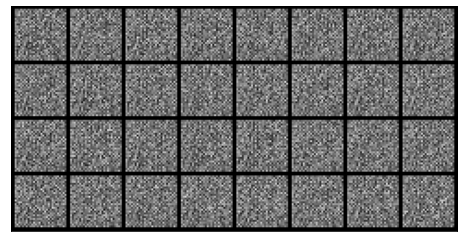

In [6]:
def denorm(img_tensors,mean=0.5,std=0.5):
    return img_tensors * std + mean
def show_images(images, nmax=32):
    images = images.cpu()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach())[:nmax], nrow=8).permute(1, 2, 0))
    plt.show()
noise_vector = torch.rand((32,512,1,1),dtype=torch.float32,device=device)
fake_image = Gen(noise_vector)
show_images(fake_image)

In [7]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
#show_tensor_images(fake_image)

In [8]:
def get_noise(bathc_size=32,latent_size = 512):
    return torch.rand((bathc_size,latent_size,1,1),dtype=torch.float32,device=device)

In [9]:
def Discriminator_train(opt_discriminator,criterion,real_image):
    opt_discriminator.zero_grad()
    ### in fake ###
    noise = get_noise()
    fake_image = Gen(noise)
    fake_predict = Dis(fake_image)
    fake_loss = criterion(fake_predict,torch.zeros_like(fake_predict))
    ### in real ###
    real_predict = Dis(real_image)
    real_loss = criterion(real_predict,torch.ones_like(real_predict))
    loss = fake_loss + real_loss
    loss.backward()
    opt_discriminator.step()
    return loss.item()

def check_D_train():
    opt = torch.optim.Adam(Dis.parameters(),lr = 0.1)
    criterion = F.binary_cross_entropy
    real_image = trainloader.dataset.data[:32].unsqueeze(1).float().to(device)
    loss = Discriminator_train(opt,criterion,real_image)
    print("Well! \nDiscriminator loss = %.3f" %loss)

#check_D_train()



In [10]:
def Generator_train(opt_generator,criterion):
    opt_generator.zero_grad()
    noise = get_noise()
    
    fake_image = Gen(noise)
    predict = Dis(fake_image)
    loss = criterion(predict,torch.zeros_like(predict))
    print_loss = loss.item()
    loss.backward()
    opt_generator.step()
    return print_loss

def check_G_train():
    opt = torch.optim.Adam(Dis.parameters(),lr = 0.1)
    criterion = F.binary_cross_entropy
    loss = Generator_train(opt,criterion)
    print("Well! \Generator loss = %.3f" %loss)

#check_G_train()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 33.0568, loss_d: 65.5005


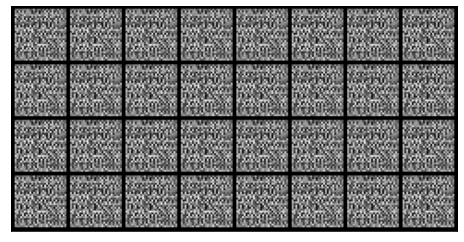

  2%|▏         | 2/100 [00:01<01:33,  1.05it/s]

Epoch [2/100], loss_g: 32.1255, loss_d: 64.5252


  3%|▎         | 3/100 [00:02<01:27,  1.11it/s]

Epoch [3/100], loss_g: 31.9696, loss_d: 63.7926


  4%|▍         | 4/100 [00:03<01:23,  1.15it/s]

Epoch [4/100], loss_g: 31.6457, loss_d: 62.9095


  5%|▌         | 5/100 [00:04<01:20,  1.17it/s]

Epoch [5/100], loss_g: 30.7083, loss_d: 61.2083
Epoch [6/100], loss_g: 25.5188, loss_d: 51.6335


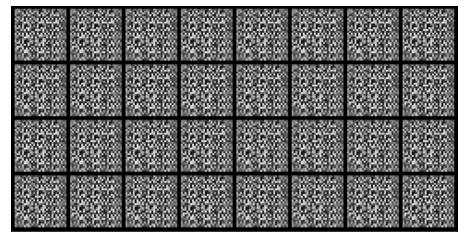

  7%|▋         | 7/100 [00:06<01:19,  1.16it/s]

Epoch [7/100], loss_g: 21.3674, loss_d: 41.7753


  8%|▊         | 8/100 [00:06<01:17,  1.18it/s]

Epoch [8/100], loss_g: 18.9973, loss_d: 36.4382


  9%|▉         | 9/100 [00:07<01:16,  1.19it/s]

Epoch [9/100], loss_g: 17.3844, loss_d: 32.9114


 10%|█         | 10/100 [00:08<01:14,  1.20it/s]

Epoch [10/100], loss_g: 15.4715, loss_d: 29.3911
Epoch [11/100], loss_g: 14.1007, loss_d: 26.6017


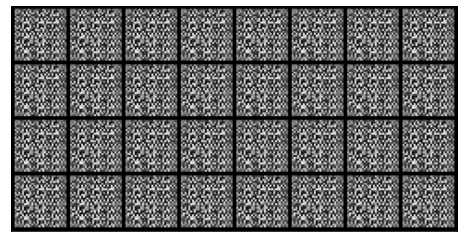

 12%|█▏        | 12/100 [00:10<01:15,  1.16it/s]

Epoch [12/100], loss_g: 13.0974, loss_d: 24.3494


 13%|█▎        | 13/100 [00:11<01:13,  1.18it/s]

Epoch [13/100], loss_g: 12.0031, loss_d: 22.2568


 14%|█▍        | 14/100 [00:12<01:12,  1.19it/s]

Epoch [14/100], loss_g: 10.9619, loss_d: 20.1025


 15%|█▌        | 15/100 [00:12<01:11,  1.19it/s]

Epoch [15/100], loss_g: 10.1125, loss_d: 18.3890
Epoch [16/100], loss_g: 9.2320, loss_d: 16.8481


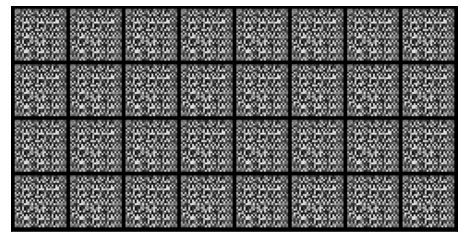

 17%|█▋        | 17/100 [00:14<01:11,  1.16it/s]

Epoch [17/100], loss_g: 8.8088, loss_d: 15.8304


 18%|█▊        | 18/100 [00:15<01:09,  1.18it/s]

Epoch [18/100], loss_g: 7.8170, loss_d: 14.5337


 19%|█▉        | 19/100 [00:16<01:08,  1.18it/s]

Epoch [19/100], loss_g: 7.3971, loss_d: 13.5139


 20%|██        | 20/100 [00:17<01:06,  1.20it/s]

Epoch [20/100], loss_g: 6.7725, loss_d: 12.4013
Epoch [21/100], loss_g: 6.4368, loss_d: 11.7099


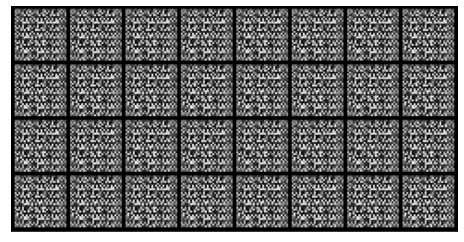

 22%|██▏       | 22/100 [00:18<01:07,  1.16it/s]

Epoch [22/100], loss_g: 5.8512, loss_d: 10.8379


 23%|██▎       | 23/100 [00:19<01:05,  1.17it/s]

Epoch [23/100], loss_g: 5.3887, loss_d: 9.8281


 24%|██▍       | 24/100 [00:20<01:04,  1.18it/s]

Epoch [24/100], loss_g: 5.0684, loss_d: 9.0738


 25%|██▌       | 25/100 [00:21<01:03,  1.19it/s]

Epoch [25/100], loss_g: 4.6990, loss_d: 8.4256
Epoch [26/100], loss_g: 4.3884, loss_d: 7.7862


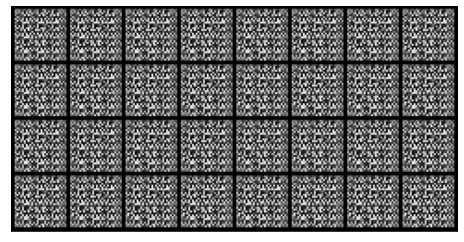

 27%|██▋       | 27/100 [00:23<01:03,  1.15it/s]

Epoch [27/100], loss_g: 4.0675, loss_d: 7.3454


 28%|██▊       | 28/100 [00:24<01:01,  1.17it/s]

Epoch [28/100], loss_g: 3.8344, loss_d: 6.9493


 29%|██▉       | 29/100 [00:24<01:00,  1.17it/s]

Epoch [29/100], loss_g: 3.6045, loss_d: 6.4894


 30%|███       | 30/100 [00:25<00:59,  1.18it/s]

Epoch [30/100], loss_g: 3.2280, loss_d: 6.1294
Epoch [31/100], loss_g: 3.1991, loss_d: 5.6983


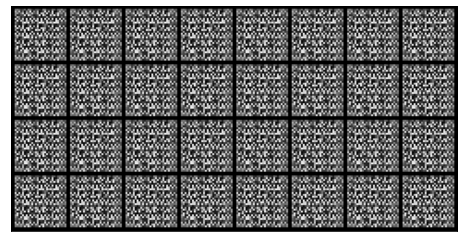

 32%|███▏      | 32/100 [00:27<01:00,  1.13it/s]

Epoch [32/100], loss_g: 3.0348, loss_d: 5.3524


 33%|███▎      | 33/100 [00:28<00:58,  1.15it/s]

Epoch [33/100], loss_g: 2.8236, loss_d: 5.2199


 34%|███▍      | 34/100 [00:29<00:56,  1.17it/s]

Epoch [34/100], loss_g: 2.6906, loss_d: 4.8201


 35%|███▌      | 35/100 [00:30<00:55,  1.18it/s]

Epoch [35/100], loss_g: 2.5964, loss_d: 4.5968
Epoch [36/100], loss_g: 2.4071, loss_d: 4.2803


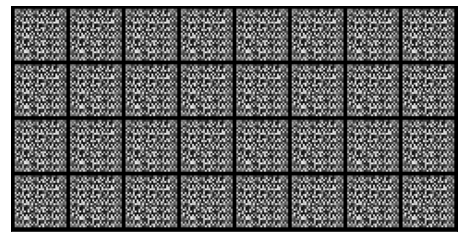

 37%|███▋      | 37/100 [00:31<00:55,  1.14it/s]

Epoch [37/100], loss_g: 2.3002, loss_d: 4.0522


 38%|███▊      | 38/100 [00:32<00:53,  1.16it/s]

Epoch [38/100], loss_g: 2.1512, loss_d: 3.8490


 39%|███▉      | 39/100 [00:33<00:52,  1.17it/s]

Epoch [39/100], loss_g: 2.0240, loss_d: 3.6037


 40%|████      | 40/100 [00:34<00:50,  1.18it/s]

Epoch [40/100], loss_g: 1.9396, loss_d: 3.4364
Epoch [41/100], loss_g: 1.8464, loss_d: 3.2880


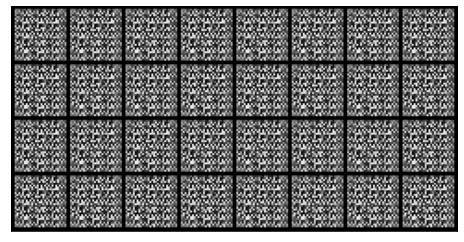

 42%|████▏     | 42/100 [00:36<00:50,  1.14it/s]

Epoch [42/100], loss_g: 1.7664, loss_d: 3.0818


 43%|████▎     | 43/100 [00:37<00:49,  1.15it/s]

Epoch [43/100], loss_g: 1.6688, loss_d: 2.9045


 44%|████▍     | 44/100 [00:37<00:48,  1.17it/s]

Epoch [44/100], loss_g: 1.6878, loss_d: 2.8917


 45%|████▌     | 45/100 [00:38<00:47,  1.16it/s]

Epoch [45/100], loss_g: 1.5392, loss_d: 2.7417
Epoch [46/100], loss_g: 1.4800, loss_d: 2.6379


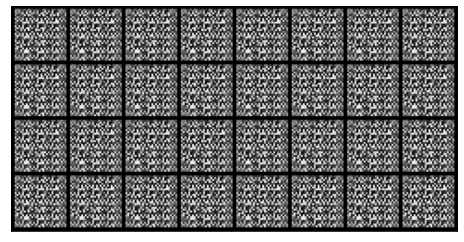

 47%|████▋     | 47/100 [00:40<00:47,  1.13it/s]

Epoch [47/100], loss_g: 1.3878, loss_d: 2.3993


 48%|████▊     | 48/100 [00:41<00:45,  1.14it/s]

Epoch [48/100], loss_g: 1.3865, loss_d: 2.3108


 49%|████▉     | 49/100 [00:42<00:45,  1.13it/s]

Epoch [49/100], loss_g: 1.3329, loss_d: 2.3197


 50%|█████     | 50/100 [00:43<00:44,  1.13it/s]

Epoch [50/100], loss_g: 1.2315, loss_d: 2.1588
Epoch [51/100], loss_g: 1.1784, loss_d: 2.0865


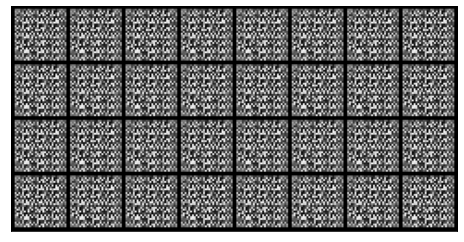

 52%|█████▏    | 52/100 [00:45<00:45,  1.06it/s]

Epoch [52/100], loss_g: 1.1503, loss_d: 2.0052


 53%|█████▎    | 53/100 [00:46<00:43,  1.07it/s]

Epoch [53/100], loss_g: 1.1012, loss_d: 1.9124


 54%|█████▍    | 54/100 [00:47<00:42,  1.09it/s]

Epoch [54/100], loss_g: 1.0343, loss_d: 1.8144


 55%|█████▌    | 55/100 [00:47<00:41,  1.10it/s]

Epoch [55/100], loss_g: 1.0089, loss_d: 1.8215
Epoch [56/100], loss_g: 0.9569, loss_d: 1.7163


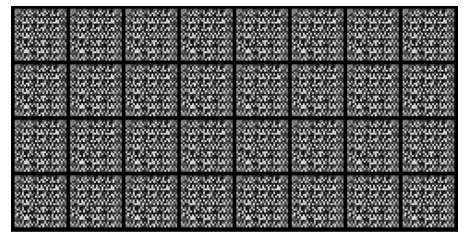

 57%|█████▋    | 57/100 [00:49<00:40,  1.06it/s]

Epoch [57/100], loss_g: 0.9388, loss_d: 1.6732


 58%|█████▊    | 58/100 [00:50<00:39,  1.08it/s]

Epoch [58/100], loss_g: 0.9465, loss_d: 1.6437


 59%|█████▉    | 59/100 [00:51<00:37,  1.09it/s]

Epoch [59/100], loss_g: 0.9001, loss_d: 1.5707


 60%|██████    | 60/100 [00:52<00:36,  1.09it/s]

Epoch [60/100], loss_g: 0.8303, loss_d: 1.4608
Epoch [61/100], loss_g: 0.7766, loss_d: 1.4289


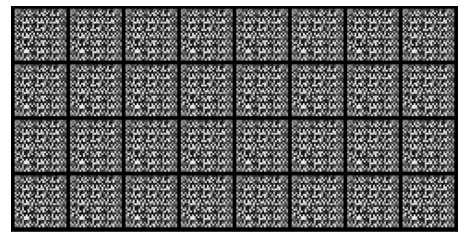

 62%|██████▏   | 62/100 [00:54<00:35,  1.06it/s]

Epoch [62/100], loss_g: 0.7329, loss_d: 1.3371


 63%|██████▎   | 63/100 [00:55<00:34,  1.08it/s]

Epoch [63/100], loss_g: 0.7401, loss_d: 1.2884


 64%|██████▍   | 64/100 [00:56<00:33,  1.09it/s]

Epoch [64/100], loss_g: 0.7227, loss_d: 1.3070


 65%|██████▌   | 65/100 [00:57<00:32,  1.09it/s]

Epoch [65/100], loss_g: 0.6620, loss_d: 1.1684
Epoch [66/100], loss_g: 0.6687, loss_d: 1.1569


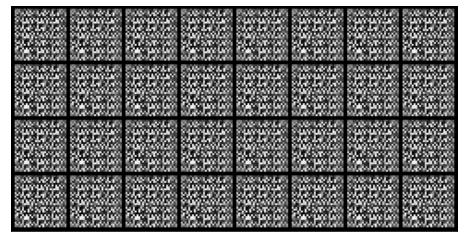

 67%|██████▋   | 67/100 [00:59<00:31,  1.05it/s]

Epoch [67/100], loss_g: 0.7130, loss_d: 1.2105


 68%|██████▊   | 68/100 [01:00<00:29,  1.07it/s]

Epoch [68/100], loss_g: 0.6070, loss_d: 1.0901


 69%|██████▉   | 69/100 [01:01<00:29,  1.06it/s]

Epoch [69/100], loss_g: 0.5889, loss_d: 1.0293


 70%|███████   | 70/100 [01:02<00:27,  1.07it/s]

Epoch [70/100], loss_g: 13.7659, loss_d: 12.6566
Epoch [71/100], loss_g: 5.3919, loss_d: 9.9550


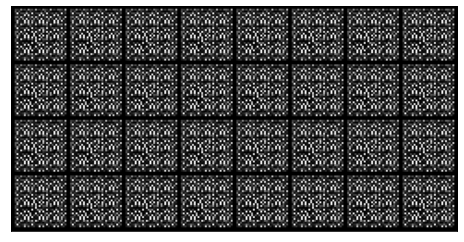

 72%|███████▏  | 72/100 [01:04<00:26,  1.04it/s]

Epoch [72/100], loss_g: 1.0221, loss_d: 2.5562


 73%|███████▎  | 73/100 [01:05<00:25,  1.05it/s]

Epoch [73/100], loss_g: 0.8206, loss_d: 1.9820


 74%|███████▍  | 74/100 [01:05<00:24,  1.07it/s]

Epoch [74/100], loss_g: 0.7195, loss_d: 1.6286


 75%|███████▌  | 75/100 [01:06<00:23,  1.07it/s]

Epoch [75/100], loss_g: 0.6720, loss_d: 1.4602
Epoch [76/100], loss_g: 0.6303, loss_d: 1.2997


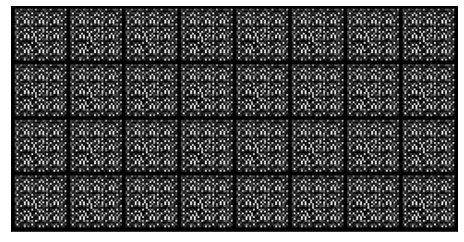

 77%|███████▋  | 77/100 [01:08<00:21,  1.07it/s]

Epoch [77/100], loss_g: 0.5946, loss_d: 1.2318


 78%|███████▊  | 78/100 [01:09<00:20,  1.09it/s]

Epoch [78/100], loss_g: 0.5743, loss_d: 1.1204


 79%|███████▉  | 79/100 [01:10<00:18,  1.11it/s]

Epoch [79/100], loss_g: 0.5510, loss_d: 1.0393


 80%|████████  | 80/100 [01:11<00:17,  1.12it/s]

Epoch [80/100], loss_g: 0.5267, loss_d: 1.0017
Epoch [81/100], loss_g: 0.5150, loss_d: 0.9549


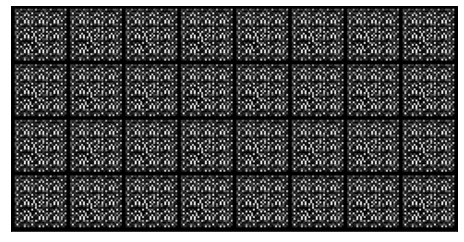

 82%|████████▏ | 82/100 [01:13<00:16,  1.11it/s]

Epoch [82/100], loss_g: 0.5125, loss_d: 0.9359


 83%|████████▎ | 83/100 [01:14<00:15,  1.12it/s]

Epoch [83/100], loss_g: 0.4751, loss_d: 0.8990


 84%|████████▍ | 84/100 [01:14<00:14,  1.11it/s]

Epoch [84/100], loss_g: 0.4839, loss_d: 0.8802


 85%|████████▌ | 85/100 [01:15<00:13,  1.12it/s]

Epoch [85/100], loss_g: 0.4581, loss_d: 0.8320
Epoch [86/100], loss_g: 0.4504, loss_d: 0.7824


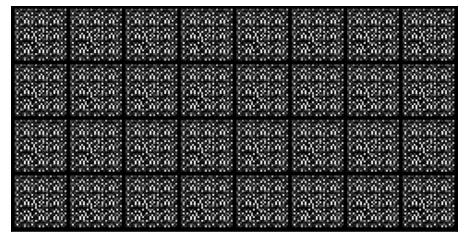

 87%|████████▋ | 87/100 [01:17<00:11,  1.10it/s]

Epoch [87/100], loss_g: 0.4281, loss_d: 0.7384


 88%|████████▊ | 88/100 [01:18<00:10,  1.12it/s]

Epoch [88/100], loss_g: 0.4366, loss_d: 0.7132


 89%|████████▉ | 89/100 [01:19<00:09,  1.13it/s]

Epoch [89/100], loss_g: 0.4144, loss_d: 0.6942


 90%|█████████ | 90/100 [01:20<00:08,  1.15it/s]

Epoch [90/100], loss_g: 0.4118, loss_d: 0.6779
Epoch [91/100], loss_g: 0.3664, loss_d: 0.6537


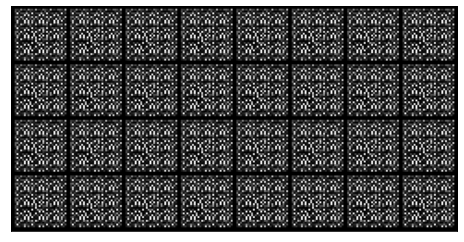

 92%|█████████▏| 92/100 [01:22<00:07,  1.10it/s]

Epoch [92/100], loss_g: 0.3623, loss_d: 0.6293


 93%|█████████▎| 93/100 [01:23<00:06,  1.10it/s]

Epoch [93/100], loss_g: 0.3765, loss_d: 0.6091


 94%|█████████▍| 94/100 [01:23<00:05,  1.12it/s]

Epoch [94/100], loss_g: 0.3629, loss_d: 0.6223


 95%|█████████▌| 95/100 [01:24<00:04,  1.13it/s]

Epoch [95/100], loss_g: 0.3508, loss_d: 0.5767
Epoch [96/100], loss_g: 0.3385, loss_d: 0.5612


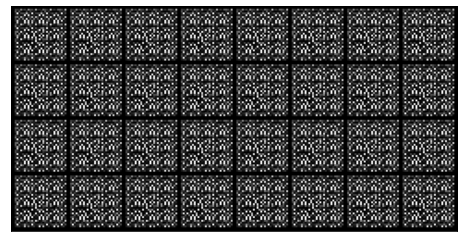

 97%|█████████▋| 97/100 [01:26<00:02,  1.09it/s]

Epoch [97/100], loss_g: 0.3245, loss_d: 0.5396


 98%|█████████▊| 98/100 [01:27<00:01,  1.11it/s]

Epoch [98/100], loss_g: 0.3288, loss_d: 0.5382


 99%|█████████▉| 99/100 [01:28<00:00,  1.13it/s]

Epoch [99/100], loss_g: 0.2996, loss_d: 0.5024


100%|██████████| 100/100 [01:29<00:00,  1.12it/s]

Epoch [100/100], loss_g: 0.3028, loss_d: 0.5087


In [11]:
def trainGAN(gen_opt,discr_opt,criterion,loader,epoch):
    for i in tqdm(range(epoch)):
        Dis.train()
        Gen.train()
        epoch_gen_loss = 0
        epoch_dis_loss = 0
        for image, _ in loader:
            image = image.to(device)
            epoch_dis_loss += Discriminator_train(discr_opt,criterion,image)
            epoch_gen_loss += Generator_train(gen_opt,criterion)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}".format(
            i+1, epoch, epoch_gen_loss, epoch_dis_loss))
        if i%5 == 0:
            with torch.no_grad():
                Dis.eval()
                Gen.eval()
                noise = get_noise()
                fake_image = Gen(noise)
                fake_image = fake_image.detach().cpu()
                show_images(fake_image)


Dis = Dis.to(device)
Gen = Gen.to(device)
opt_d = torch.optim.Adam(Dis.parameters(), lr=2e-4)
opt_g = torch.optim.Adam(Gen.parameters(), lr=2e-4)
criterion = F.binary_cross_entropy
trainGAN(opt_g,opt_d,criterion,trainloader,100)


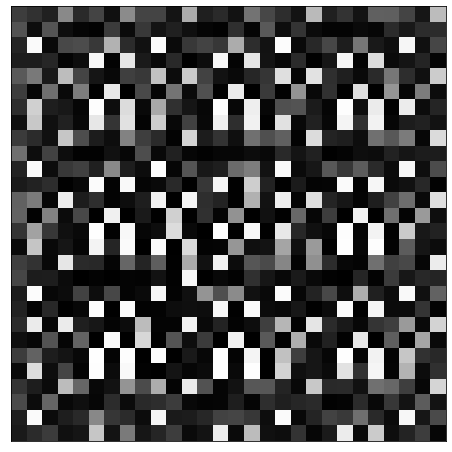

In [12]:
noise = get_noise(bathc_size=1)
Gen.eval()
fake_image = Gen(noise)
show_images(fake_image)

Вывод:
1.   Не всегда Upsample + Conv2d работают лучше, чем ConvTransponse2d. В данном случае ConvTr2d дал более высокие результаты
2.   Обучить сеть не удалось. Возможно это связано со сложностью представления одежды. С другой стороны получился вполне рабочий генератор QR кодов.


